In [102]:
## IMPORTANT: On Colab, we expect your homework to be in the cs189 folder
## Please contact staff if you encounter any problems with installing dependencies
import sys
IS_COLAB = 'google.colab' in sys.modules
if IS_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    %cd /content/drive/MyDrive/cs189/hw/hw3
    %pip install -r ./requirements.txt
    !pip install -U kaleido plotly
    import kaleido
    kaleido.get_chrome_sync()

import plotly.io as pio
pio.renderers.default = pio.renderers.default + "+png"


In [103]:
# Initialize Otter
import otter
grader = otter.Notebook("hw3.ipynb")

<link rel="stylesheet" href="berkeley.css">

<h1 class="cal cal-h1">Homework 03 – Optimizers and Backpropagation</h1>

CS 189, Fall 2025

Welcome to Homework 3! In this assignment, you will use your newfound skills in backpropagation to implement an autodifferentiation library from scratch. You'll extend the single-variable autograd that we learned in lecture to function with general tensors, mimicking how `torch`'s autograd is implemented in research and industry.

---

## Due Date: November 7th, 2025

This assignment is due on **November 7th, 2025**. You must submit your work to Gradescope by this deadline. Please refer to the syllabus for the [Slip Day policy](https://eecs189.org/fa25/syllabus/#slip-days). No late submissions will be accepted beyond the details outlined in the Slip Day policy.

### Submission Tips
- **Plan ahead**: We strongly encourage you to submit your work several hours before the deadline. This will give you ample time to address any submission issues.
- **Reach out for help early**: If you encounter difficulties, contact course staff well before the deadline. While we are happy to assist with submission issues, we cannot guarantee responses to last-minute requests.

<!-- ---

### Assignment Overview

This notebook contains a series of tasks designed to help you practice and apply theoretical concepts you learned in class.

Question 1: Implementing Backpropagation

Question 2 : Implementing Optimizers

--- -->

### Key Learning Objectives

1. Learn how backpropagation is implemented in libraries like PyTorch
2. Understand how optimizers are implemented, and the advantages of Adam
    
---

### Collaboration Policy
You are encouraged to discuss high-level concepts with your peers. However:
- All submitted work must be written in your own words and code.
- Do not share or copy solutions directly.
- List any collaborators (students you worked with) in the line below. Include their name and SID:

**Your Collaborators**: **TODO**

### AI Tools Usage Disclosure
We allow the use of AI tools (e.g., ChatGPT, Copilot) **only as support**, not as a replacement for your own reasoning. To ensure transparency, you must acknowledge any use of AI tools.

Please answer with one of the following options:
- **A) I did not use any AI tools for this homework.**
- **B) I used AI tools in the following way(s):**  
  (describe briefly, e.g., “Used ChatGPT to get hints for debugging a NumPy indexing error”)


**Your Answer**: **TODO**
    
---

### Grading Breakdown

<!-- <div align="center"> -->


| Question  | Manual Grading? | Points |
| --------- | --------------- | ------ |
| q1        | No              | 10     |
| q2        | No              | 20     |
| q3        | No              | 10     |
| q4        | No              | 10     |
| **Total** |                 | **50** |


In [104]:
from __future__ import annotations
import numpy as np
from dataclasses import dataclass
import matplotlib.pyplot as plt
from collections import deque
import typst
import re
np.random.seed(189)

**Introducing BearTensor** 

Before we can dig into our multivariable calculus, we first need a good abstraction for tensors,
which are just $n$-dimensional arrays (similar to `numpy`'s `ndarray`). `numpy` doesn't
provide autodifferentiation for its `ndarray`, so we can build a wrapper around it. For this homework assignment we are going to be using the `BearTensor` class, which you can think of as a custom implementation of `torch.Tensor` that acts as a wrapper around `numpy` arrays.

Take a look at the `BearTensor`, `BearGrad`, and `BearParent` classes below.

**Question 1**: Building the Computation Graph

**Conceptual Overview**:

Our model needs some way to build a computation graph for backpropagation so that it knows where to pass down gradients during the backwards pass. The way that PyTorch does this, is that every time you combine two values to compute a third one in the forward pass, it will keep track of this internally. We want to implement a similar functionality for `BearTensor`; everytime we add, subtract, divide, etc. two `BearTensor` to get a third one, we should keep track of the fact that the third tensor's **parents** are the two source tensors. 

Here is an example of what a computation graph might look like from lecture:
<div style="text-align: center;">
  <img src="https://imgur.com/PO3S6TI.png" alt="Backpropagation" style="display: block; margin-left: auto; margin-right: auto; width: 60%;">
</div>

**Your Task**:

Currently, our `BearTensor` has no operations. Implement the following functions in the class:
- Addition (`__add__`)
- Subtraction (`__sub__`)
- Multiplication (`__mul__`)
- Power (`__pow__`)
- Matrix multiplication (`__matmul__`)
- Dot product (`dot`)
- Sum (`sum`)
- Mean (`mean`)
- ReLU (`relu`)
- Sigmoid (`sigmoid`)

A few things to remember:
1. You should return a new `BearTensor` from these functions without modifying the existing one
2. Remember to set the parents of this new Tensor to be the two source tensors; this is how we will build a computation graph
3. Remember to set the correct gradient function as the first argument of `BearParent.BearGrad`; this will tell us how to compute the downstream gradient during the backward pass

Additionally, we are going to be doing a lot NumPy operations in this Homework. It is important that you think about how the shapes of different arrays will change due to NumPy broadcasting rules, and reshape when needed. Some examples of this that are relevant to this HW are:
- NumPy will automatically broadcast 1-element arrays to a scalar (ex. when computing the dot product of two vectors)
- NumPy will broadcast array of shape (N, 1) to just (N,) (ex. when a matrix times a matrix gives a vector)

**Note**: The public tests that we've provided in this notebook are NOT fully-comprehensive and often very simple. You should build more complex graphs and manually verify that your computed gradients and values are correct. Our hidden tests are more comprehensive and will check for full correctness 


In [114]:
@dataclass
class BearGrad:
    '''Stores how to compute the downstream gradient from the upstream gradient 
    - `op_str` is just a string describing the operation; you don't need to use this for this HW, but it may help in debugging if you print out what operations create your computation graph.
    - `fn` is a function that takes in the upstream loss gradient and outputs the loss gradient that should be passed downstream. This essentially applies the chain rule at the current node in the computation graph.
    '''
    fn: callable
    op_str: str | None = None

@dataclass
class BearParent:
    '''This class represents a parent of a node; a node must track its parents so that it knows who to propagate its gradients to.
    - `grad` is the `BearGrad` object for this parent; we can apply the `fn` from this to compute the gradient that should be passed downstream.
    - `parent` is the `BearTensor` object for the parent
    '''
    parent: BearTensor
    grad: BearGrad

    def __hash__(self):
        return id(self)

    def __eq__(self, other):
        return self is other

class BearTensor:
    '''`BearTensor`: This represents a node in our computation graph
    - `value` is the underlying data in the Tensor; this is computed during the forward pass
    - `parents` keeps track of the parents in the computation graph to whom we pass our gradient to
    - `adjoint` is the gradient (the transpose of it technically) that we compute in the backward pass
    '''
    def __init__(self, name: str, value: np.ndarray, parents: list[BearParent] | None = None):
        self.name = name
        self.value = value
        self.parents = parents if parents is not None else []
        self.adjoint: float | np.ndarray = 0.0

    def __add__(self, other: BearTensor) -> BearTensor:
        if self.value.shape != other.value.shape:
            raise ValueError("Shapes must match")
        result_value = self.value + other.value
        
        # For addition: gradient flows equally to both parents
        parents = [
            BearParent(self, BearGrad(lambda g: g, op_str="add_left")),
            BearParent(other, BearGrad(lambda g: g, op_str="add_right"))
        ]
        
        return BearTensor(f"({self.name}+{other.name})", result_value, parents)

    def __sub__(self, other: BearTensor) -> BearTensor:
        if self.value.shape != other.value.shape:
            raise ValueError("Shapes must match")
        result_value = self.value - other.value
        
        parents = [
            BearParent(self, BearGrad(lambda g: g, op_str="sub_left")),
            BearParent(other, BearGrad(lambda g: -g, op_str="sub_right"))
        ]
        
        return BearTensor(f"({self.name}-{other.name})", result_value, parents)

    def __mul__(self, other: BearTensor) -> BearTensor:
        if self.value.shape != other.value.shape:
            raise ValueError("Shapes must match")
        result_value = self.value * other.value
        
        parents = [
            BearParent(self, BearGrad(lambda g: g * other.value, op_str="mul_left")),
            BearParent(other, BearGrad(lambda g: g * self.value, op_str="mul_right"))
        ]
        
        return BearTensor(f"({self.name}*{other.name})", result_value, parents)

    def __pow__(self, power: float) -> BearTensor:
        result_value = self.value ** power
        
        def grad_fn(upstream_grad):
            # d/dx (x^p) = p * x^(p-1)
            return upstream_grad * power * (self.value ** (power - 1))
        
        parents = [
            BearParent(self, BearGrad(grad_fn, op_str="pow"))
        ]
        
        return BearTensor(f"({self.name}^{power})", result_value, parents)

    def __matmul__(self, other: BearTensor) -> BearTensor:
        # This may be helpful to avoid shape mismatch errors
        def ensure_2d(x):
            '''If x is a scalar or 1-D, convert to 2-D'''
            x = np.asarray(x)
            if x.ndim == 0:          # scalar
                return x.reshape(1, 1)
            elif x.ndim == 1:        # vector
                return x.reshape(-1, 1)  # column vector convention
            else:                     # already 2D
                return x
        
        self_2d = ensure_2d(self.value)
        other_2d = ensure_2d(other.value)
        result_value = self_2d @ other_2d
        
        # Handle broadcasting: if result is (N,1), reshape to (N,)
        if result_value.shape[1] == 1 and result_value.shape[0] > 1:
            result_value = result_value.flatten()
        
        def grad_fn_left(upstream_grad):
            # d/dA (A @ B) = upstream_grad @ B^T
            upstream_2d = ensure_2d(upstream_grad)
            other_2d = ensure_2d(other.value)
            grad = upstream_2d @ other_2d.T
            # Reshape to match original shape
            if self.value.ndim == 1:
                return grad.flatten()
            elif self.value.ndim == 0:
                return grad.item()
            return grad
        
        def grad_fn_right(upstream_grad):
            # d/dB (A @ B) = A^T @ upstream_grad
            upstream_2d = ensure_2d(upstream_grad)
            self_2d = ensure_2d(self.value)
            grad = self_2d.T @ upstream_2d
            # Reshape to match original shape
            if other.value.ndim == 1:
                return grad.flatten()
            elif other.value.ndim == 0:
                return grad.item()
            return grad
        
        parents = [
            BearParent(self, BearGrad(grad_fn_left, op_str="matmul_left")),
            BearParent(other, BearGrad(grad_fn_right, op_str="matmul_right"))
        ]
        
        return BearTensor(f"({self.name}@{other.name})", result_value, parents)

    def dot(self, other: BearTensor) -> BearTensor:
        if self.value.ndim != 1 or other.value.ndim != 1:
            raise ValueError("dot() only supports 1-D BearTensors (like torch.dot).")
        result_value = np.dot(self.value, other.value)
        # Ensure result is a 1D array, not a scalar
        if result_value.ndim == 0:
            result_value = np.array([result_value])
        
        def grad_fn_left(upstream_grad):
            # d/dx (x · y) = upstream_grad * y
            # Handle scalar upstream_grad
            if isinstance(upstream_grad, (int, float)) or (isinstance(upstream_grad, np.ndarray) and upstream_grad.ndim == 0):
                upstream_grad = np.array([upstream_grad]) if isinstance(upstream_grad, (int, float)) else upstream_grad.reshape(1)
            return upstream_grad[0] * other.value if upstream_grad.ndim == 1 else upstream_grad * other.value
        
        def grad_fn_right(upstream_grad):
            # d/dy (x · y) = upstream_grad * x
            # Handle scalar upstream_grad
            if isinstance(upstream_grad, (int, float)) or (isinstance(upstream_grad, np.ndarray) and upstream_grad.ndim == 0):
                upstream_grad = np.array([upstream_grad]) if isinstance(upstream_grad, (int, float)) else upstream_grad.reshape(1)
            return upstream_grad[0] * self.value if upstream_grad.ndim == 1 else upstream_grad * self.value
        
        parents = [
            BearParent(self, BearGrad(grad_fn_left, op_str="dot_left")),
            BearParent(other, BearGrad(grad_fn_right, op_str="dot_right"))
        ]
        
        return BearTensor(f"({self.name}.dot({other.name}))", result_value, parents)

    def sum(self) -> BearTensor:
        result_value = np.sum(self.value)
        # Ensure result is a 1D array, not a scalar
        if result_value.ndim == 0:
            result_value = np.array([result_value])
        
        def grad_fn(upstream_grad):
            # d/dx sum(x) = upstream_grad broadcasted to shape of x
            # Handle scalar or array upstream_grad
            if isinstance(upstream_grad, (int, float)):
                scalar_grad = float(upstream_grad)
            elif isinstance(upstream_grad, np.ndarray):
                if upstream_grad.ndim == 0:
                    scalar_grad = float(upstream_grad.item())
                elif upstream_grad.ndim == 1 and upstream_grad.size == 1:
                    scalar_grad = float(upstream_grad[0])
                else:
                    scalar_grad = float(upstream_grad.flat[0])
            else:
                scalar_grad = float(upstream_grad)
            return np.full_like(self.value, scalar_grad)
        
        parents = [
            BearParent(self, BearGrad(grad_fn, op_str="sum"))
        ]
        
        return BearTensor(f"{self.name}.sum()", result_value, parents)

    def mean(self) -> BearTensor:
        result_value = np.mean(self.value)  # 保持 scalar

        n = self.value.size

        def grad_fn(upstream_grad):
            # upstream_grad 一定是 scalar
            return np.ones_like(self.value) * (upstream_grad / n)

        parents = [
            BearParent(self, BearGrad(grad_fn, op_str="mean"))
        ]

        return BearTensor(f"{self.name}.mean()", result_value, parents)

    
    def relu(self) -> BearTensor:
        result_value = np.maximum(0, self.value)
        
        def grad_fn(upstream_grad):
            # d/dx ReLU(x) = 1 if x > 0, else 0
            mask = (self.value > 0).astype(upstream_grad.dtype)
            return upstream_grad * mask
        
        parents = [
            BearParent(self, BearGrad(grad_fn, op_str="relu"))
        ]
        
        return BearTensor(f"{self.name}.relu()", result_value, parents)

    def sigmoid(self) -> BearTensor:
        # Use numerically stable sigmoid: 1 / (1 + exp(-x))
        # For large negative x, use: exp(x) / (1 + exp(x))
        x = self.value
        # Clip to avoid overflow
        x_clipped = np.clip(x, -500, 500)
        exp_neg_x = np.exp(-x_clipped)
        result_value = 1 / (1 + exp_neg_x)
        
        def grad_fn(upstream_grad):
            # d/dx sigmoid(x) = sigmoid(x) * (1 - sigmoid(x))
            sigmoid_val = result_value
            return upstream_grad * sigmoid_val * (1 - sigmoid_val)
        
        parents = [
            BearParent(self, BearGrad(grad_fn, op_str="sigmoid"))
        ]
        
        return BearTensor(f"{self.name}.sigmoid()", result_value, parents)

**Disclaimer**: The Q1 test cases will NOT test that your adjoint calculations are correct until you implement Q2; if you are struggling with the next question, we recommend also looking back at your solution to Q1.

In [115]:
grader.check("q1")

q1 results: All test cases passed!

Below, we have provided some code that will allow you to visualize your computation graphs and an example for how to use it. You are not required to use nor understand how this works, but it may help you debug while working on this homework.

In [116]:
def to_typst_math(s: str) -> str:
    processed_s = s
    processed_s = processed_s.replace(" @ ", " ")
    processed_s = re.sub(r"([a-zA-Z])([0-9]+)", r"\1_\2", processed_s)
    processed_s = re.sub(r"\.([a-zA-Z]+)", r'."\1"', processed_s)
    processed_s = re.sub(r"([a-zA-Z]+)_([a-zA-Z_]+)", r'\1_"\2"', processed_s)
    processed_s = re.sub(r"\b(relu|sum)\b", r'"\1"', processed_s)
    return processed_s


def _traverse_graph(
    root: BearTensor,
) -> tuple[list[BearTensor], list[tuple[BearTensor, BearTensor, str]]]:
    nodes, edges = set(), set()
    visited = set()

    def build(v):
        if v not in visited:
            visited.add(v)
            nodes.add(v)
            for p in v.parents:
                edges.add((p.parent, v, p.grad.op_str))
                build(p.parent)

    build(root)
    return list(nodes), list(edges)


def _minimize_crossings(
    nodes_by_level: list[list[BearTensor]],
    edges: list[tuple[BearTensor, BearTensor, str]],
    iterations: int = 4,
) -> list[list[BearTensor]]:
    node_to_parents = {n: [] for level in nodes_by_level for n in level}
    node_to_children = {n: [] for level in nodes_by_level for n in level}
    for p, c, _ in edges:
        if p in node_to_children and c in node_to_parents:
            node_to_children[p].append(c)
            node_to_parents[c].append(p)

    ordered_levels = [list(level) for level in nodes_by_level]

    for _ in range(iterations):
        for level_idx in range(1, len(ordered_levels)):
            child_level = ordered_levels[level_idx - 1]
            child_ranks = {node: rank for rank, node in enumerate(child_level)}

            def barycenter_down(node):
                children = node_to_children.get(node, [])
                if not children:
                    return -1
                avg_rank = sum(child_ranks.get(c, 0) for c in children) / len(children)
                return avg_rank

            ordered_levels[level_idx].sort(key=barycenter_down)

        for level_idx in range(len(ordered_levels) - 2, -1, -1):
            parent_level = ordered_levels[level_idx + 1]
            parent_ranks = {node: rank for rank, node in enumerate(parent_level)}

            def barycenter_up(node):
                parents = node_to_parents.get(node, [])
                if not parents:
                    return -1
                avg_rank = sum(parent_ranks.get(p, 0) for p in parents) / len(parents)
                return avg_rank

            ordered_levels[level_idx].sort(key=barycenter_up)

    return ordered_levels


def _assign_node_levels(
    root: BearTensor,
    nodes: list[BearTensor],
    edges: list[tuple[BearTensor, BearTensor, str]],
) -> dict[BearTensor, tuple[float, float]]:
    node_to_id = {node: i for i, node in enumerate(nodes)}
    id_to_node = {i: node for i, node in enumerate(nodes)}

    adj = {node_to_id[n]: [] for n in nodes}
    for p, c, _ in edges:
        if c in node_to_id and p in node_to_id:
            adj[node_to_id[c]].append(node_to_id[p])

    levels = {n: -1 for n in nodes}
    if root in levels:
        levels[root] = 0

    q = deque([root])
    max_level = 0
    visited_bfs = {root}

    while q:
        u = q.popleft()
        u_id = node_to_id[u]
        for v_id in adj.get(u_id, []):
            v = id_to_node.get(v_id)
            if v and v not in visited_bfs:
                levels[v] = levels[u] + 1
                max_level = max(max_level, levels[v])
                visited_bfs.add(v)
                q.append(v)

    nodes_by_level = [[] for _ in range(max_level + 1)]
    for node, level in levels.items():
        if level != -1:
            nodes_by_level[level].append(node)

    for level_nodes in nodes_by_level:
        level_nodes.sort(key=lambda n: n.name)

    nodes_by_level = _minimize_crossings(nodes_by_level, edges)

    node_coords = {}
    for level, nodes_in_level in enumerate(nodes_by_level):
        num_in_level = len(nodes_in_level)
        for rank, node in enumerate(nodes_in_level):
            y_pos = rank - (num_in_level - 1) / 2.0
            x_pos = -level
            node_coords[node] = (x_pos, y_pos)

    return node_coords


def _generate_typst_source(
    nodes: list[BearTensor],
    edges: list[tuple[BearTensor, BearTensor, str]],
    coords: dict[BearTensor, tuple[float, float]],
) -> str:
    node_to_id = {node: i for i, node in enumerate(nodes)}

    header = """#import "@preview/fletcher:0.5.8": diagram, node, edge
#set page(width: auto, height: auto, margin: 10mm, fill: white)
#set text(font: "Linux Libertine", size: 10pt)

#diagram(cell-size: (40mm, 40mm), {
"""

    node_definitions = ""
    for n in nodes:
        if n not in coords:
            continue
        x, y = coords[n]
        node_id = node_to_id[n]
        math_name = to_typst_math(n.name)
        shape_str = str(n.value.shape)
        content = f"""block(stroke: 0.5pt, inset: 8pt, radius: 4pt, [\n#align(center, ${math_name}$)\n#line(length: 100%)\n#text(size: 9pt, `shape: {shape_str}`)\n])"""
        node_definitions += f'  node(({x}, {y}), {content}, name: "{node_id}")\n'

    edge_definitions = ""
    LABEL_LENGTH_THRESHOLD = 20

    for parent, child, op_str in edges:
        from_id = node_to_id.get(parent)
        to_id = node_to_id.get(child)
        if from_id is None or to_id is None:
            continue

        op_str = op_str or ""
        if op_str:
            math_op_str = to_typst_math(op_str)
            # Format label as Typst string literal - escape quotes properly
            # Typst syntax: label: "$math$"
            # We need to escape the $ signs and quotes in the generated code
            label_str = f'${math_op_str}$'
            # Escape any quotes in the label string
            label_str = label_str.replace('"', '\\"')
            label_expr = f'"{label_str}"'
        else:
            label_expr = '""'

        if len(op_str) > LABEL_LENGTH_THRESHOLD:
            edge_definitions += f'  edge(label("{from_id}"), label("{to_id}"), "->", label: {label_expr}, label-sep: 4em)\n'
        else:
            edge_definitions += (
                f'  edge(label("{from_id}"), label("{to_id}"), "->", label: {label_expr})\n'
            )

    footer = "})"

    return header + node_definitions + edge_definitions + footer


def draw_graph(root: BearTensor, output_typ_path: str = "computational_graph.typ"):
    nodes, edges = _traverse_graph(root)
    coords = _assign_node_levels(root, nodes, edges)
    typst_source = _generate_typst_source(nodes, edges, coords)

    with open(output_typ_path, "w", encoding="utf-8") as f:
        f.write(typst_source)
    typst.compile(output_typ_path, output=output_typ_path.replace(".typ", ".pdf"))

# Example code
a = BearTensor("a", np.array([2, 3]))
b = BearTensor("b", np.array([1, 1]))
c = a + b
draw_graph(c, "demo_graph.typ")

**Question 2**:

After solving the previous question, your `BearTensor` should be able to construct the computation graph from the forward pass. In this part, we will implement the backwards pass, using the `BearGrad` functionality from above to propagate the gradients downstream.

**Conceptual Overview**

When training networks, we want to backpropagate the gradients starting from the very final node, which produced our training loss. To do this efficiently, we adopt a recursive approach; the loss node propagates its gradient back to its parent nodes. Then, every parent node propagates its gradient one layer further back; we keep recursively doing this until gradients have been propagated across the whole computation graph.

In lecture, we implemented single-variable `autograd` with two passes when `.backward()` is called: 
a "reset" pass that sets up counters for each node in our computational graph, 
and then a recursive backward pass to iterate through the entire graph and accumulate each node's adjoint.

We can actually perform both of these steps at once using an algorithm called <i>topological sort</i>.
This addresses the core problem we are trying to solve: a node can only propagate its gradient backward after it has received gradients from all its children.

[Topological sort](https://en.wikipedia.org/wiki/Topological_sorting) starts from the root node (where we call
`.backward()`), and traverses our computational graph to determine a correct order of operations. From Wikipedia: 
it provides a linear ordering that ensures that for any edge $u \to v$ in our computational graph, $u$ comes before
$v$ in the ordering. It turns out that *depth-first search (DFS)* actually gives us a topological sort!

You should first implement topological sort, then backprop; this ensures that for deep networks we do not encounter a stack overflow error. One implementation of this is [Kahn's algorithm](https://www.geeksforgeeks.org/dsa/topological-sorting-indegree-based-solution/) which is iterative instead of recursive, avoiding stack overflow errors for deep networks. Alternatively, you can use the implementation discussed in lecture.

**Your Task:**

Fill out `topological_sort` first, then `reset_children`, and `backward` below to implement backpropagation. After completing this, you finally have your very own PyTorch implementation!

In [117]:
def topological_sort(node):
    '''Return a list of nodes ordered topologically'''
    visited = set()
    sorted_nodes = []
    
    def dfs(n):
        if n in visited:
            return
        visited.add(n)
        # Visit all parents first (they come before this node in topological order)
        for parent in n.parents:
            dfs(parent.parent)
        sorted_nodes.append(n)
    
    dfs(node)
    return sorted_nodes

In [118]:
def reset_children(self):
    """Resets the gradient in the current node to zero and all nodes before it in the computation graph."""
    # Get all nodes in topological order
    sorted_nodes = topological_sort(self)
    
    # Reset adjoint to zero for all nodes
    for node in sorted_nodes:
        if isinstance(node.value, np.ndarray):
            node.adjoint = np.zeros_like(node.value)
        else:
            node.adjoint = 0.0

def backward(self):
    """
    Take a node in the computation graph, reset all gradients, and perform backpropagation 
    to compute the adjoints (gradients) for all nodes in the graph.

    Hint: After resetting the gradients, what should the gradient at the current node be?
    """
    # Reset all gradients first
    self.reset_children()
    
    # Set the gradient at the current node (root) to 1.0
    # For scalar or 1D array results (like sum, mean), use array([1.0])
    if isinstance(self.value, np.ndarray):
        if self.value.ndim == 0:
            # Scalar: use [1.0]
            self.adjoint = np.array([1.0])
        elif self.value.ndim == 1 and self.value.size == 1:
            # Single-element 1D array: use [1.0]
            self.adjoint = np.array([1.0])
        else:
            # Multi-element array: use ones_like
            self.adjoint = np.ones_like(self.value)
    else:
        # Python scalar
        self.adjoint = 1.0
    
    # Get nodes in reverse topological order (from root to leaves)
    sorted_nodes = topological_sort(self)
    sorted_nodes.reverse()
    
    # Backpropagate gradients
    for node in sorted_nodes:
        # For each parent, compute and accumulate the gradient
        for parent_info in node.parents:
            parent = parent_info.parent
            grad_fn = parent_info.grad.fn
            
            # Compute gradient to pass to parent
            parent_grad = grad_fn(node.adjoint)
            
            # Accumulate gradient in parent (sum if multiple children)
            # Ensure both are arrays or both are scalars for proper addition
            if isinstance(parent.adjoint, np.ndarray):
                if isinstance(parent_grad, np.ndarray):
                    # Both are arrays - add directly (NumPy handles broadcasting)
                    parent.adjoint = parent.adjoint + parent_grad
                else:
                    # parent_grad is scalar, convert to array
                    parent.adjoint = parent.adjoint + np.full_like(parent.adjoint, parent_grad)
            else:
                if isinstance(parent_grad, np.ndarray):
                    # parent.adjoint is scalar but parent_grad is array - convert adjoint to array
                    parent.adjoint = np.zeros_like(parent_grad) + parent_grad
                else:
                    # Both are scalars
                    parent.adjoint = parent.adjoint + parent_grad

BearTensor.reset_children = reset_children
BearTensor.backward = backward

In [119]:
grader.check("q2")

q2 results: All test cases passed!

**Question 3: Optimizers**

Now that we are able to compute the gradients for all the parameters in our model, we want to be able to optimize them. In lecture we talked about Gradient Descent; in this homework, we will implement two widely-used optimizers, Stochastic Gradient Descent and Adam. It is highly recommended that you complete the paper/written portion of the homework before attempting this question.

**Your Task**:

Implement the SGD, Momentum, and Adam optimizers.

In [123]:
class Optimizer:
    def __init__(self, params: list[BearTensor], lr: float):
        self.params = params
        self.lr = lr

    def zero_grad(self):
        for p in self.params:
            p.adjoint = np.zeros_like(p.value)

    def step(self):
        raise NotImplementedError

class SGD(Optimizer):
    def __init__(self, params: list[BearTensor], lr: float):
        super().__init__(params, lr)

    def step(self):
        for param in self.params:
            # Update: param = param - lr * gradient
            param.value = param.value - self.lr * param.adjoint

class Momentum(Optimizer):
    def __init__(self, params: list[BearTensor], lr: float, beta: float = 0.9):
        super().__init__(params, lr)
        self.beta = beta
        self.velocities = [np.zeros_like(p.value) for p in self.params]

    def step(self):
        for i, param in enumerate(self.params):
            # Update velocity: v = beta * v + gradient
            self.velocities[i] = self.beta * self.velocities[i] - self.lr * param.adjoint
            # Update parameter: param = param - lr * velocity
            param.value = param.value + self.velocities[i]


class Adam(Optimizer):
    def __init__(
        self,
        params: list[BearTensor],
        lr: float,
        beta1: float = 0.9,
        beta2: float = 0.999,
        eps: float = 1e-8,
    ):
        super().__init__(params, lr)
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.t = 0
        self.ms = [np.zeros_like(p.value) for p in self.params]
        self.vs = [np.zeros_like(p.value) for p in self.params]

    def step(self):
        self.t += 1
        for i, param in enumerate(self.params):
            # Update biased first moment estimate
            self.ms[i] = self.beta1 * self.ms[i] + (1 - self.beta1) * param.adjoint
            # Update biased second raw moment estimate
            self.vs[i] = self.beta2 * self.vs[i] + (1 - self.beta2) * (param.adjoint ** 2)
            
            # Compute bias-corrected first moment estimate
            m_hat = self.ms[i] / (1 - self.beta1 ** self.t)
            # Compute bias-corrected second raw moment estimate
            v_hat = self.vs[i] / (1 - self.beta2 ** self.t)
            
            # Update parameter
            param.value = param.value - self.lr * m_hat / (np.sqrt(v_hat) + self.eps)

In [124]:
grader.check("q3")

q3 results: All test cases passed!

The code below compares the convergence rates of all 3 optimizers. Play around with the learning rates and other hyperparameters to see how the results change.

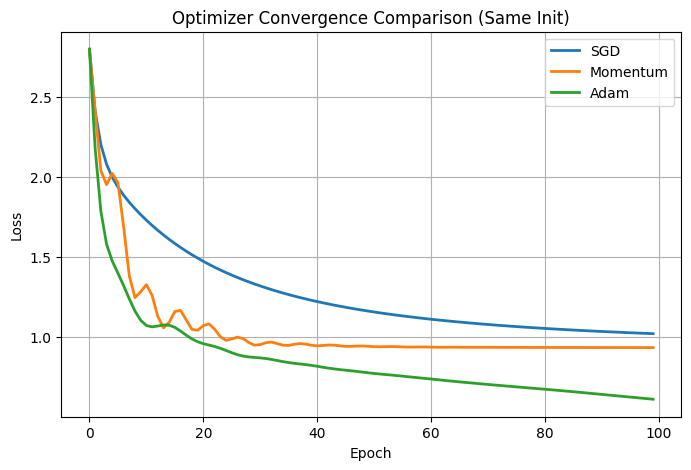

In [126]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

def compare_optimizers(optimizers):
    np.random.seed(0)
    X = BearTensor("X", np.random.randn(1000, 24))
    y = BearTensor("y", np.random.randn(1000))
    
    n_steps = 100
    results = {}

    W1_init = np.random.randn(24, 12)
    W2_init = np.random.randn(12)

    for opt_class, title, lr in optimizers:
        W1 = BearTensor("W1", deepcopy(W1_init))
        W2 = BearTensor("W2", deepcopy(W2_init))
        params = [W1, W2]

        optimizer = opt_class(params, lr=lr)
        losses = []

        for step in range(n_steps):
            optimizer.zero_grad()

            hidden = (X @ W1).sigmoid()
            output = hidden @ W2
            loss = ((output - y) ** 2).mean()

            loss.backward()
            losses.append(loss.value.item())
            optimizer.step()

        results[title] = losses

    plt.figure(figsize=(8, 5))
    for title, losses in results.items():
        plt.plot(losses, label=title, linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Optimizer Convergence Comparison (Same Init)")
    plt.legend()
    plt.grid(True)
    plt.show()

compare_optimizers([
    (SGD, "SGD", 0.05),
    (Momentum, "Momentum", 0.05),
    (Adam, "Adam", 0.05)
])

**Question 4: Train a model!**

In this section, we're going to use the backpropagation engine and optimizers you created to train a model to predict wine quality scores!

**Conceptual Overview:**

Unfortunately, training our model is going to be slightly more involved than just using PyTorch. Our simple implementation does not allow us to define layers. Instead, we are going to define `BearTensors`, combine them manually to do a forward pass (which will automatically construct a computation graph!) and then finally backpropagate on our loss.

We are going to use the Wine Quality dataset, which contains 1599 samples of red wine. Each sample has 11 features representing various chemical properties, and the task is to predict the wine quality score (between 0 and 10). You can choose any loss function and optimizer (as long as you implemented it!) of your choice, feel free to play around with hyperparameters and different model sizes!

**Your Tasks:**

Train a model to predict wine quality scores. Your model should:
- Use at least one hidden layer
- Use an activation function for hidden layers
- Achieve a Mean Squared Error (MSE) of ≤ 2.0 on the dataset

**You need to fill in the `predict()` function that uses your architecture to return a prediction given an input datapoint. The autograder will use this to test your implementation**.

**Note**: If your model takes more than 30 seconds to train it could crash the autograder; you should easily be able to **achieve a MSE of ≤2** on the entire dataset with a 1-layer neural net for full credit. The staff solution takes <1 second to train, so if your code is slow, you may be constructing your graph inefficiently.

**You will receive 50% credit for this question if your MSE is ≤ 3.0 on the dataset.**

Tips for training models:
- Output your training and test loss every epoch; are they smoothly going down? If not, you may need to change the learning rate
- Ensure your computation graph is being built properly (remember our visualization helper functions from earlier!)
- Changing the number of layers or adding/removing bias terms can be a useful way to control how much your model is overfitting/underfitting

In [136]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# DO NOT CHANGE THE PREPROCESSING CODE
data = fetch_openml("wine-quality-red", as_frame=True)
X = data.data.to_numpy()
y = data.target.to_numpy().astype(float)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.4, random_state=42, shuffle=True
)

X_tensor = BearTensor("X_train", X_train)               # shape: (N_train, input_dim)
y_tensor = BearTensor("y_train", y_train.reshape(-1,1)) # shape: (N_train,1)

# Add your training code here!
# Initialize model parameters
input_dim = X_train.shape[1]
hidden_dim = 32
output_dim = 1

# Initialize weights with small random values
np.random.seed(42)
W1 = BearTensor("W1", np.random.randn(input_dim, hidden_dim) * 0.1)
b1 = BearTensor("b1", np.zeros((1, hidden_dim)))
W2 = BearTensor("W2", np.random.randn(hidden_dim, output_dim) * 0.1)
b2 = BearTensor("b2", np.zeros((1, output_dim)))

params = [W1, b1, W2, b2]

# Use Adam optimizer
optimizer = Adam(params, lr=0.01)

# Training loop
n_epochs = 200
train_losses = []
test_losses = []

for epoch in range(n_epochs):
    optimizer.zero_grad()
    
    # Forward pass
    # X_tensor shape: (N_train, input_dim)
    # W1 shape: (input_dim, hidden_dim)
    N = X_tensor.value.shape[0]

    b1_exp = BearTensor("b1_exp", np.repeat(b1.value, N, axis=0))
    hidden = (X_tensor @ W1 + b1_exp).relu()

    out_linear = hidden @ W2                      # 先拿出来
    b2_exp = BearTensor(
        "b2_exp",
    np.repeat(b2.value.reshape(-1), out_linear.value.shape[0])
    )
    output = out_linear + b2_exp
    
    # Compute loss (MSE)
    y_flat = BearTensor("y_flat", y_tensor.value.reshape(-1))
    loss = ((output - y_flat) ** 2).mean()
    
    # Backward pass
    loss.backward()
    
    # Update parameters
    optimizer.step()
    
    # Compute training loss
    train_loss = loss.value.item()
    train_losses.append(train_loss)
    
    # Compute test loss (without gradient computation)
    X_test_tensor = BearTensor("X_test", X_test)
    y_test_tensor = BearTensor("y_test", y_test.reshape(-1, 1))
    N_test = X_test_tensor.value.shape[0]

    b1_exp_test = BearTensor("b1_exp_test", np.repeat(b1.value, N_test, axis=0))
    hidden_test = (X_test_tensor @ W1 + b1_exp_test).relu()

    # Compute output linear part first to get correct shape
    out_linear_test = hidden_test @ W2
    # Expand b2 to match the shape of out_linear_test
    b2_exp_test = BearTensor(
        "b2_exp_test",
        np.repeat(b2.value.reshape(-1), out_linear_test.value.shape[0])
    )
    output_test = out_linear_test + b2_exp_test
    test_loss = ((output_test.value - y_test_tensor.value.reshape(-1)) ** 2).mean()
    test_losses.append(test_loss)
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

print(f"\nFinal Train MSE: {train_losses[-1]:.4f}")
print(f"Final Test MSE: {test_losses[-1]:.4f}")

# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.grid(True)
plt.show()

# --- Prediction function ---
def predict(x):
    """Output the scalar prediction for a single training datapoint x"""
    # x is a single datapoint, shape: (input_dim,)
    x_tensor = BearTensor("x", x.reshape(1, -1))  # Reshape to (1, input_dim)
    
    # Forward pass (using trained weights)
    hidden = (x_tensor @ W1 + BearTensor("b1_exp", b1.value)).relu()
    output = hidden @ W2 + BearTensor("b2_exp", b2.value)
    
    # Return scalar prediction
    return output.value.item()


ValueError: Shapes must match

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
## Use this cell if you are running the notebook in Google Colab to install the necessary dependencies, this may take a few minutes
if IS_COLAB:
    !apt-get install -y texlive texlive-xetex pandoc


In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False, run_tests=True)